#

# 14. Learning on Sequence Data


## CPE 490 590
## Rahul Bhadani

In [56]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the 3x3 edge detection filter
edge_filter = torch.tensor([[0, 1, 0],
                            [1, -4, 1],
                            [0, 1, 0]], dtype=torch.float32)

# Sobel - Horizontal
sobel_x = torch.tensor([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=torch.float32)

# Sobel - Vertical
sobel_y = torch.tensor([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]], dtype=torch.float32)

# Prewitt - Horizontal
prewitt_x = torch.tensor([[-1, 0, 1],
                        [-1, 0, 1],
                        [-1, 0, 1]], dtype=torch.float32)

# Prewitt - Vertical
prewitt_y = torch.tensor([[1, 1, 1],
                        [0, 0, 0],
                        [-1, -1, -1]], dtype=torch.float32)

# Roberts Cross (3x3 version) - Diagonal
roberts_x = torch.tensor([[0, 0, 0],
                        [0, 1, -1],
                        [0, 0, 0]], dtype=torch.float32)

# Roberts Cross (3x3 version) - Anti-diagonal
roberts_y = torch.tensor([[0, 0, 0],
                        [0, 1, 0],
                        [0, -1, 0]], dtype=torch.float32)

# Laplacian - 4-connectivity
laplacian_4 = torch.tensor([[0, 1, 0],
                            [1, -4, 1],
                            [0, 1, 0]], dtype=torch.float32)

# Laplacian - 8-connectivity
laplacian_8 = torch.tensor([[1, 1, 1],
                            [1, -8, 1],
                            [1, 1, 1]], dtype=torch.float32)

# Kirsch - North
kirsch_n = torch.tensor([[-3, -3, -3],
                        [-3, 0, -3],
                        [5, 5, 5]], dtype=torch.float32)

# Kirsch - East
kirsch_e = torch.tensor([[-3, -3, 5],
                        [-3, 0, 5],
                        [-3, -3, 5]], dtype=torch.float32)

# Robinson - North
robinson_n = torch.tensor([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]], dtype=torch.float32)

# Frei-Chen
frei_chen = torch.tensor([[1/torch.sqrt(torch.tensor(2.0)), 0, -1/torch.sqrt(torch.tensor(2.0))],
                        [1, 0, -1],
                        [1/torch.sqrt(torch.tensor(2.0)), 0, -1/torch.sqrt(torch.tensor(2.0))]], dtype=torch.float32)

sobel_filter = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32)
# zero_filter = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], dtype=torch.float32)


In [61]:
# Load and preprocess the image
image_path = '../figures/grayscale.jpg'
# Load and preprocess data
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale -- Optional
    transforms.ToTensor(),  # Convert images to tensors
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values == Needs this if not converting to grayscale
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values (single channel)
])



In [62]:
image = Image.open(image_path)
input_tensor = transform(image)#.unsqueeze(0)  # Add batch dimension


# Apply the convolutional filter
conv_layer = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
#conv_layer = nn.Conv2d(3, 1, kernel_size=3, padding=1, bias=False) # Needs this if not converting to grayscale
conv_layer.weight.data[0, 0] = edge_filter
# conv_layer.weight.data[0, 1] = edge_filter # second channel in the colored image
# conv_layer.weight.data[0, 2] = edge_filter  # second channel in the colored image
output_tensor = conv_layer(input_tensor)

# Convert output tensor back to an image
filtered_image = transforms.ToPILImage()(output_tensor.squeeze(0))



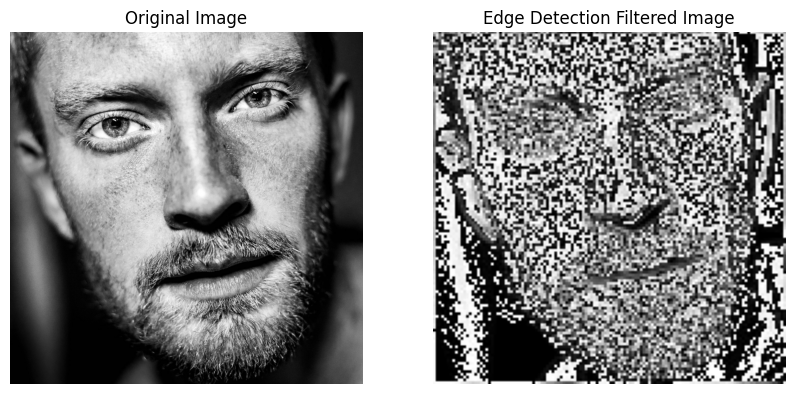

In [64]:
# Display the original and filtered images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis("off")
axs[1].imshow(filtered_image, cmap="gray")
axs[1].set_title("Edge Detection Filtered Image")
axs[1].axis("off")
plt.savefig("../figures/Edge_detection.pdf")
plt.show()

# 1. Convolutional Neural Network on Cats / Dogs Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
# Define the CNN architecture
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
         # First convolutional layer: 3 input channels (RGB images), 16 output channels (filters), 3x3 kernel, and padding of 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Second convolutional layer: 16 input channels, 32 output channels, 3x3 kernel, and padding of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Max-pooling layer: 2x2 kernel and stride of 2 (reduces spatial dimensions by half)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # First fully connected layer: 32*32*32 input features (flattened), 128 output features
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        # Final fully connected layer: 128 input features, 2 output features (cat or dog)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: cat and dog

    def forward(self, x):
         # Apply conv1, ReLU activation, and max-pooling
        x = self.pool(torch.relu(self.conv1(x)))
        # Apply conv2, ReLU activation, and max-pooling
        x = self.pool(torch.relu(self.conv2(x)))
         # Flatten the output tensor to a 1D vector
        x = x.view(-1, 32 * 32 * 32)
       # Pass through fc1 with ReLU activation
        x = torch.relu(self.fc1(x))
        # Compute output logits using fc2
        x = self.fc2(x)
        return x

In [3]:

# Load and preprocess data
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])


In [4]:
# Define the CatDogDataset class
import os
class CatDogDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        """
        Args:
            root_folder (str): Path to the root folder containing cat and dog images.
            transform (callable, optional): Optional transform to apply to the images.
        """
        # Set the root folder path
        self.root = root_folder
        # Store the image transformation function (if provided)
        self.transform = transform
        # Define the classes (assuming subfolders are named "cat" and "dog")
        self.classes = ["Cat_Small", "Dog_Small"]
        # Initialize an empty list to store image filenames
        self.elements = []

        # Collect image filenames
        for class_name in self.classes:
            # Create the full path to the class-specific folder
            class_folder = os.path.join(self.root, class_name)
            # Iterate through files in the class folder
            for filename in os.listdir(class_folder):
                # Check if the file has a ".jpg" extension
                if filename.endswith(".jpg"):
                    # Append the full path of the image file to the list
                    self.elements.append(os.path.join(class_name, filename))

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.elements)

    def __getitem__(self, index):
        # Open the image using PIL (Pillow)
        img = Image.open(os.path.join(self.root, self.elements[index].rstrip()))
        # Convert the image to RGB format (if it was grayscale)
        img = img.convert("RGB")
        # Determine the target label (index of the class in self.classes)
        target = self.classes.index(self.elements[index].rstrip().split('/')[0])
        # Return the image and its corresponding label
        image, label = img, target

        # Apply the specified transformation (if provided)
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [5]:
# Create training and test datasets
root_folder = '../Data/CatsDogs/PetImages'
dataset = CatDogDataset(root_folder, transform=transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


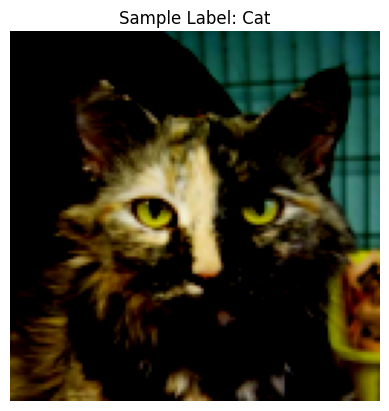

In [6]:
# Visualize a random sample
import numpy as np
random_idx = np.random.randint(len(dataset))
sample_img, sample_label = dataset[random_idx]

# Convert the PyTorch tensor to a NumPy array
sample_img_np = sample_img.numpy().transpose(1, 2, 0)  # Channels last

# Display the image
plt.imshow(sample_img_np)
plt.title(f"Sample Label: {'Cat' if sample_label == 0 else 'Dog'}")
plt.axis('off')
plt.show()


In [7]:
# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

from torch.utils.data import DataLoader, random_split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 317
Test dataset size: 80


In [8]:
# Initialize the model and optimizer
model = CatDogCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/3] - Loss: 0.7473
Epoch [2/3] - Loss: 0.6166
Epoch [3/3] - Loss: 0.5469


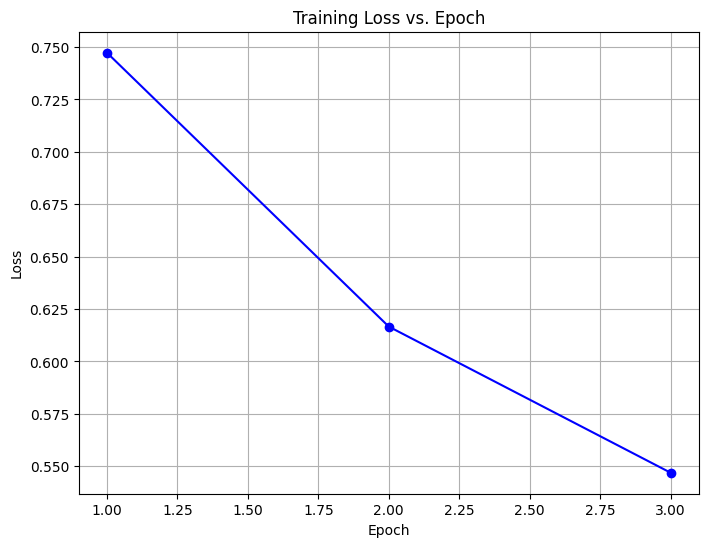

In [9]:
# Training loop (you can adjust the number of epochs and batch size)
num_epochs = 3
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize lists to store loss values and epochs
loss_values = []
epochs = range(1, num_epochs + 1)

for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()  # Clear gradients before computing new ones
        outputs = model(images)  # Forward pass: compute model predictions
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation: compute gradients
        optimizer.step()  # Update model parameters using gradients

    # Append the loss value for this epoch
    loss_values.append(loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}")


# Create a plot for loss vs. epoch
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.grid(True)
plt.show()

In [10]:
# Evaluate the model on the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 72.50%


In [12]:
# Load the input image
input_image_path = '../Data/CatsDogs/PetImages/Dog/10001.jpg'
input_image = Image.open(input_image_path)
input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension

# Make predictions
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_class = torch.max(outputs, 1)

# Map class index to label (0 for cat, 1 for dog)
class_labels = ['Cat', 'Dog']
predicted_label = class_labels[predicted_class.item()]

print(f"Predicted label: {predicted_label}")

Predicted label: Dog
